# Subscription Churn Prediction

## Table of Contents
- [Introduction](#Introduction)
- [Data Overview  and Preparation](#Data-Overview-and-Preparation)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Model Training and Evaluation](#Model-Training-and-Evaluation)
- [Business Insights and Recommendations](#Business-Insights-and-Recommendations)

## Introduction

This project uses a dataset sourced from [Kaggle](https://www.kaggle.com/datasets/sarathperingayi/performance-of-a-subscription-business) to predict customer churn in a subscription-based business. The dataset enables an in-depth analysis of customer behaviors and preferences, crucial for understanding factors influencing churn.

## Dataset Overview
The dataset encompasses comprehensive transactional and demographic information, essential for developing models to predict the likelihood of customer churn. Key attributes include:

* **cust_id**: A unique identifier for each customer
* **transaction_type**: The type of transaction
* **transaction_date**: The date when the transaction was made
* **subscription_type**: The type of subscription, which can be BASIC, MAX, or PRO
* **subscription_price**: The price of the subscription
* **customer_gender**: The gender of the customer, which can be Male or Female
* **age_group**: The age group of the customer
* **customer_country**: The country where the customer is located
* **referral_type**: The type of referral, which can be Google Ads, Facebook, Display, or others

## Objective
The primary objective is to leverage this data to build a predictive model that identifies the likelihood of customers churning. Insights derived from this analysis will guide targeted strategies to enhance customer retention.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 75

from IPython.display import display, HTML
display(HTML('<style>.container { width:100% !important; }</style>'))

In [2]:
df = pd.read_csv('Customer_Subscription_And_Transaction_Details.csv', parse_dates=['transaction_date'])

## Data Overview and Preparation

In [3]:
df.head()

,cust_id,transaction_type,transaction_date,subscription_type,subscription_price,customer_gender,age_group,customer_country,referral_type
0,1,initial,2020-09-01,BASIC,33,Male,35-44,Denmark,Google Ads
1,2,initial,2022-03-01,BASIC,53,Female,18-24,Denmark,facebook
2,3,initial,2020-10-01,MAX,99,Female,25-34,Norway,facebook
3,3,REDUCTION,2022-02-01,BASIC,53,Female,25-34,Norway,facebook
4,4,initial,2022-05-01,PRO,85,Male,18-24,Sweden,Display


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18106 entries, 0 to 18105
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   cust_id             18106 non-null  int64         
 1   transaction_type    18106 non-null  object        
 2   transaction_date    18106 non-null  datetime64[ns]
 3   subscription_type   18106 non-null  object        
 4   subscription_price  18106 non-null  int64         
 5   customer_gender     18106 non-null  object        
 6   age_group           18106 non-null  object        
 7   customer_country    18106 non-null  object        
 8   referral_type       18106 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 1.2+ MB


In [5]:
df.duplicated().sum()

0

In [6]:
round(df.describe())

,cust_id,transaction_date,subscription_price
count,18106.00,18106,18106.00
mean,5176.00,2021-08-22 10:08:05.938363136,73.00
min,1.00,2020-01-01 00:00:00,33.00
25%,2590.00,2021-01-01 00:00:00,53.00
50%,5158.00,2021-10-01 00:00:00,75.00
75%,7767.00,2022-05-01 00:00:00,99.00
max,10366.00,2022-12-01 00:00:00,119.00
std,2989.00,NaN,28.00


In [7]:
df.describe(include='object')

,transaction_type,subscription_type,customer_gender,age_group,customer_country,referral_type
count,18106,18106,18106,18106,18106,18106
unique,4,3,3,5,4,8
top,initial,BASIC,Female,18-24,Sweden,Google Ads
freq,10366,7022,9457,4401,7009,5884


In [8]:
# Create binary target column churn from transaction_type
df['churn'] = (df['transaction_type'] == 'CHURN').astype(int)

## Data Cleaning

In [9]:
# Uppercase transaction_type levels for consistency
df['transaction_type'] = df['transaction_type'].str.upper()

In [10]:
# Duplicate transaction_dates by customer
dupe_date = df.groupby(['cust_id', 'transaction_date']).filter(lambda x: len(x) > 1)

# Indexes where `transaction_type` is not CHURN
dupe_date_index = dupe_date[dupe_date['transaction_type'] != 'CHURN'].index

# Excluding those indexes
sorted_df_1 = df[~df.index.isin(dupe_date_index)]

In [11]:
# Duplicate transaction_type by customer
dupe_transaction_type = sorted_df_1.groupby(['cust_id', 'transaction_type']).filter(lambda x: len(x) > 1)

# Excluding indexes 
dupe_transaction_type_index = dupe_transaction_type.drop_duplicates(subset=['cust_id', 'transaction_type'], keep='last').index
sorted_df_2 = sorted_df_1[~sorted_df_1.index.isin(dupe_transaction_type_index)]

# Remaining duplicate transaction_type by customer
dupe_transaction_type_1 = sorted_df_2.groupby(['cust_id', 'transaction_type']).filter(lambda x: len(x) > 1)

# Excluding indexes 
dupe_transaction_type_index_1 = dupe_transaction_type_1.drop_duplicates(subset=['cust_id', 'transaction_type'], keep='last').index
sorted_df_3 = sorted_df_2[~sorted_df_2.index.isin(dupe_transaction_type_index_1)]

In [12]:
# Renaming dataframe to indicate deduped records and resetting the index
deduped_df = sorted_df_3.copy().reset_index(drop=True)

## Feature Engineering

In [13]:
# Adding acquisition_date column
acquisition_date = deduped_df[deduped_df['transaction_type'] == 'INITIAL'][['cust_id', 'transaction_date']]
acquisition_date.rename(columns={'transaction_date': 'acquisition_date'}, inplace=True)

In [14]:
# Adding end_date column (two steps consisting of churned and non-churned customers)

# Step 1: Churned customers
end_churn = deduped_df[deduped_df['transaction_type'] == 'CHURN'][['cust_id', 'transaction_date']]
end_churn.rename(columns={'transaction_date': 'end_date'}, inplace=True)

# Customers who churned
end_churn_cust = end_churn['cust_id']

# Step2: Non-churned customers 
end_no_churn = deduped_df[~deduped_df['cust_id'].isin(end_churn_cust)][['cust_id']].drop_duplicates()

# Final date in the dataset
max_date = deduped_df[deduped_df['transaction_type'] != 'CHURN']['transaction_date'].max()

# Appending as end_date for non-churners
end_no_churn['end_date'] = max_date

# Unioning end date for churners and non-churners
end_date = pd.concat([end_churn, end_no_churn])

# Merging acquisition_date and end_date
acquisition_end = acquisition_date.merge(end_date, on='cust_id')

In [15]:
# Adding tenure column
acquisition_end['tenure'] = (acquisition_end['end_date'] - acquisition_end['acquisition_date']).dt.days

# Since transaction dates are all on the 1st of the month, tenure should represent the entire month
# so there are no customers with zero days tenure Therefore, incrementing tenure by 30
acquisition_end['tenure'] = acquisition_end['tenure'] + 30

In [16]:
# Adding avg_price column
avg_price = deduped_df.groupby(['cust_id'])[['subscription_price']].mean()
avg_price.rename(columns={'subscription_price': 'avg_price'}, inplace=True)

# Merging to the dates data frame
acquisition_end_price = acquisition_end.merge(avg_price, on='cust_id')

In [17]:
# Unique records for categorical features
cust_dems_channel = deduped_df[['cust_id', 'customer_gender', 'age_group', 'customer_country', 'referral_type']].drop_duplicates()

In [18]:
# Unique customers who churned to append churn as the final column
churned = deduped_df[deduped_df['churn'] == 1][['cust_id', 'churn']]

# Customers to exclude from non-churned data frame
churned_cust = churned['cust_id']

non_churned = deduped_df[~deduped_df['cust_id'].isin(churned_cust)][['cust_id', 'churn']].drop_duplicates()

# Union and assing to target
target = pd.concat([churned, non_churned])

In [19]:
# Merging everything into final data frame
final_df = acquisition_end_price.merge(cust_dems_channel, on='cust_id').merge(target, on='cust_id')
final_df.head()

,cust_id,acquisition_date,end_date,tenure,avg_price,customer_gender,age_group,customer_country,referral_type,churn
0,1,2020-09-01,2022-12-01,851,33.00,Male,35-44,Denmark,Google Ads,0
1,2,2022-03-01,2022-12-01,305,53.00,Female,18-24,Denmark,facebook,0
2,3,2020-10-01,2022-12-01,821,76.00,Female,25-34,Norway,facebook,0
3,4,2022-05-01,2022-12-01,244,85.00,Male,18-24,Sweden,Display,0
4,5,2022-08-01,2022-12-01,152,53.00,Male,35-44,Sweden,Google Ads,0


In [20]:
# Unique count of total customers and churned customers in initial data frame to validate against final data frame
unique_customers = df['cust_id'].nunique()
churned_customer_count = df[df['transaction_type'] == 'CHURN']['cust_id'].nunique()

# Final data frame unique customer count and target classes
final_unique_customers = final_df['cust_id'].nunique()
churn_distribution = final_df['churn'].value_counts()

if final_unique_customers == unique_customers and churn_distribution[1] == churned_customer_count:
    print(f'Unique customer count: {final_unique_customers}')
    print(f'\nChurn distribution:\n    ', churn_distribution)
else: 
    print("Total customer count and target distribution not validated")

Unique customer count: 10366

Churn distribution:
     churn
0    8314
1    2052
Name: count, dtype: int64


## Exploratory Data Analysis

In [21]:
data = final_df.copy()

### Univariate Analysis

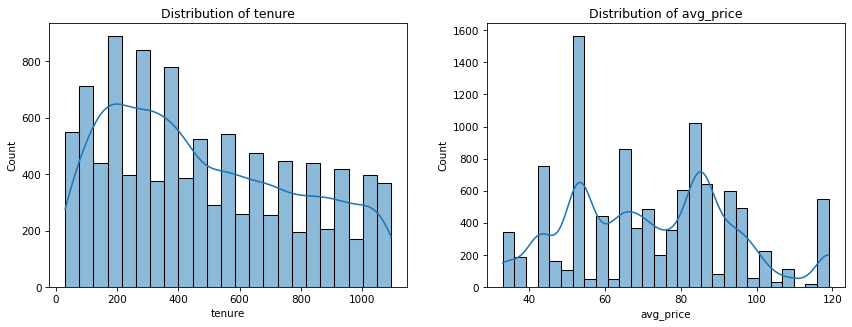

In [22]:
nums = data[['tenure', 'avg_price']].columns.tolist()
plt.figure(figsize=(12, 5))

for i, variable in enumerate(nums):
    plt.subplot(1, 2, i + 1)
    sns.histplot(data[variable], kde=True)
    plt.title(f'Distribution of {variable}')
plt.tight_layout(pad=3)
plt.show()

In [23]:
data[['tenure', 'avg_price']].describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,10366.00,483.77,301.05,30.00,221.00,425.00,729.00,1095.00
avg_price,10366.00,72.29,21.60,33.00,53.00,71.00,87.00,119.00


The median tenure is 425 days. Let's convert days into months for a clearer time-scale understanding

In [24]:
median_tenure = data['tenure'].median()
days_in_year = 365
months_in_year = 12

tenure_months = round((median_tenure / days_in_year) * months_in_year)
print(f'The median tenure is about {tenure_months} months.')

The median tenure is about 14 months.


What's the mode of avg_price?

In [25]:
data['avg_price'].mode().iloc[0]

53.0

* **Tenure**: Half of the customers churn after about 14 months, as indicated by the `tenure` column, while the other half remain customers for up to three years. This variance suggests different customer experiences and engagement levels. 
* **Average Price**: The `avg_price` column shows a bimodal distribution with peaks around \\$53 and \\$82.
    * The most frequent average price of \\$53 is located at the 25th percentile, contrasting with a cluster around \\$80 and a mean of \\$71. This indicates that a significant segment of customers choose BASIC plans, potentially missing out on more premium plan benefits. These customers are also more likely to churn earlier. 

### Multivariate Analysis

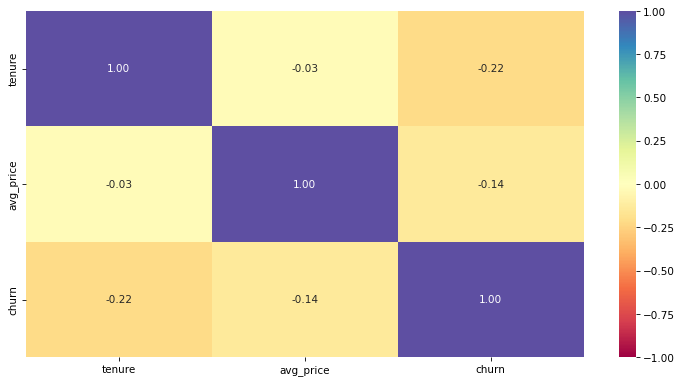

In [26]:
# Creating a list of numerical features for plotting
num_cols = data[['tenure', 'avg_price', 'churn']]
num_cols.corr()

plt.figure(figsize=(12, 6))
sns.heatmap(num_cols.corr(), annot=True, vmin=-1, vmax=1, fmt='.2f', cmap='Spectral')
plt.show()

* `churn` and `tenure`: `churn` has a slightly negative correlation with `tenure` (-0.22), suggesting that customers who keep their subscription longer are less likely to churn.
* `churn` and `avg_price`: `churn` also has a slighly negative correlation with `avg_price` (-0.14), suggesting that customers who pay more for their subscription (MAX or PRO plans vs BASIC) are less likely to churn.
* `avg_price` and `tenure`: `avg_price` has a very slight negative correlation with `tenure`.

`churn` vs numerical features

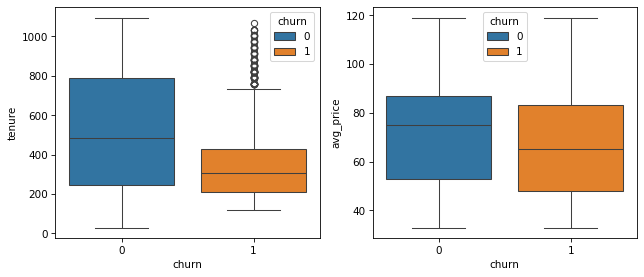

In [27]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
sns.boxplot(data=data, x='churn', y='tenure', hue='churn')

plt.subplot(122)
sns.boxplot(data=data, x='churn', y='avg_price', hue='churn')
plt.show()

* Churned customers typically have much shorter tenures than non-churners, indicating lower retention.
* Churned customers also generally pay lower average prices compared to non-churners.

`churn` vs categorical features

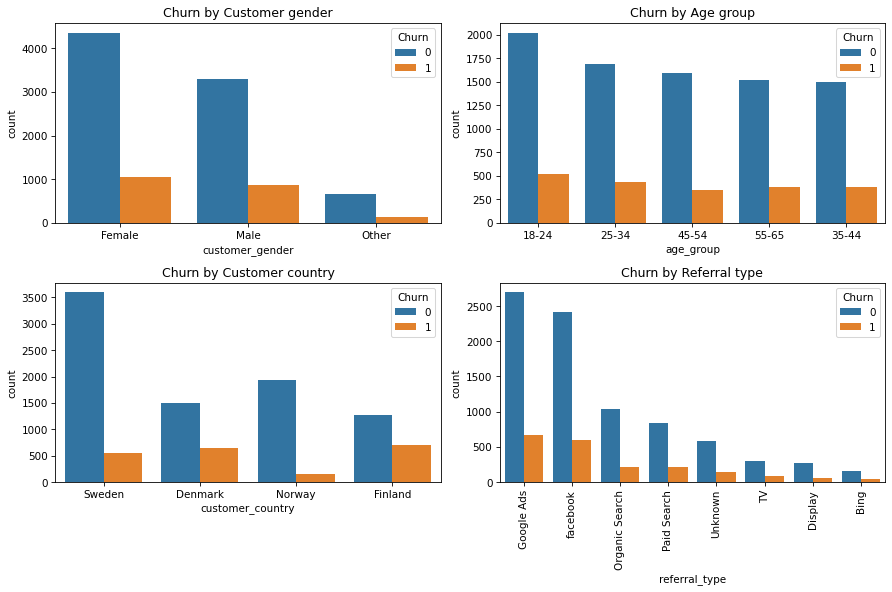

In [28]:
# Creating a list of categories for plotting
categories = ['customer_gender', 'age_group', 'customer_country', 'referral_type']

# Ordering each category for plotting
orders = {cat: data[cat].value_counts().index for cat in categories}

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()  

for i, cat in enumerate(categories[:4]): 
    sns.countplot(x=cat, hue='churn', data=data, ax=axes[i], order=orders[cat])
    axes[i].set_title(f'Churn by {cat.capitalize().replace("_", " ")}')
    axes[i].legend(title='Churn')
    if cat == 'referral_type':
        for label in axes[i].get_xticklabels():
            label.set_rotation(90)  

plt.tight_layout()
plt.show()

* The ratio of churned to non-churned appears to be split evenly among nearly all levels within `customer_gender`, `age_group`, and `referral_type`.

Churn by country has more variation, so let's take a closer look at those churn rates.

Churn by country has more variation, so let's take a closer look at those churn rates.

In [29]:
total_customers = data.groupby('customer_country')['churn'].count()
churned_customers = data[data['churn'] == 1].groupby('customer_country')['churn'].count()

churn_rate_by_country = (churned_customers / total_customers * 100).fillna(0)  # Multiplying by 100 to get a percentage
churn_rate_df = churn_rate_by_country.reset_index()
churn_rate_df.columns = ['Customer Country', 'Churn Rate (%)']
churn_rate_df.sort_values('Churn Rate (%)', ascending=False)

,Customer Country,Churn Rate (%)
1,Finland,35.44
0,Denmark,30.10
3,Sweden,13.18
2,Norway,7.55


* Finland and Denmark have the highest churn rates. Customers in Finland have about 3x churn vs Sweden and 5x churn vs Norway. 
* The company should investigate what's being done differently in Norway and Sweden that could possibly work in Finland and Denmark to lift retention rates among those customers.

What prices are customers paying across countries?

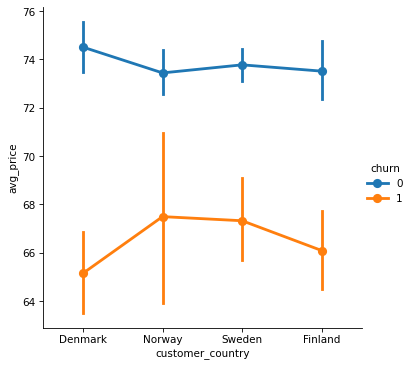

In [30]:
sns.catplot(data=data, x='customer_country', y='avg_price', kind='point', hue='churn')
plt.show()

* Churned customers are clearly paying lower average prices. This is most evident in the two countries with the highest churn rates, Denmark and Finland, which have the highest variance. 

What does churn look like over time?

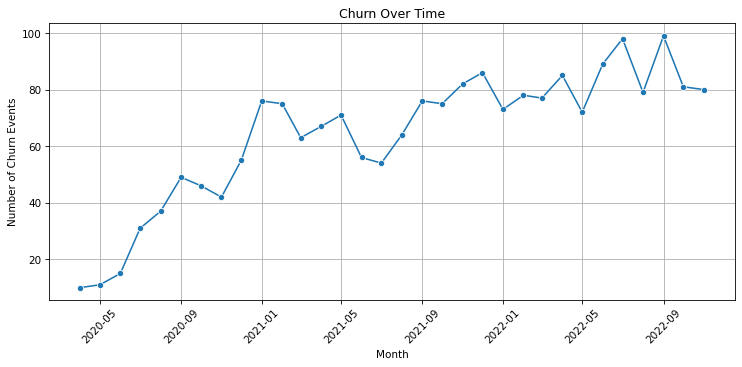

In [31]:
churn_over_time = data.groupby('end_date')['churn'].sum().reset_index()
churn_over_time = churn_over_time[:-1]

plt.figure(figsize=(10, 5))
sns.lineplot(x='end_date', y='churn', data=churn_over_time, marker='o')
plt.title('Churn Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Churn Events')
plt.grid(True)
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

* The overall churn has been increasing over the three years. 

What does avg_price look like over time?

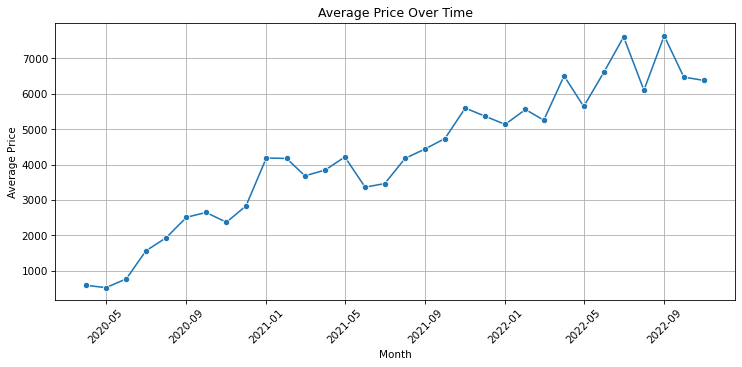

In [32]:
price_over_time = data.groupby('end_date')['avg_price'].sum().reset_index()
price_over_time = price_over_time[:-1]

plt.figure(figsize=(10, 5))
sns.lineplot(x='end_date', y='avg_price', data=price_over_time, marker='o')
plt.title('Average Price Over Time')
plt.xlabel('Month')
plt.ylabel('Average Price')
plt.grid(True)
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

## Data Preprocessing

In [33]:
# Drop unique identifiers and date columns
data.drop(columns=['cust_id', 'acquisition_date', 'end_date'], inplace=True)

# Ordinal encode age_group
age_group_mapping = {
    '18-24': 0,
    '25-34': 1,
    '35-44': 2,
    '45-54': 3,
    '55-65': 4
}

data['age_group'] = data['age_group'].map(age_group_mapping)

## Model Training and Evaluation

In [34]:
# Split the dataset
X = data.drop('churn', axis=1)
y = data['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
# Tranasform categorical and numerical columns
categorical_cols = ['customer_gender', 'customer_country', 'referral_type']
numerical_cols = ['tenure', 'avg_price', 'age_group']  # 'age_group' is now treated as numerical

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

## Model Evaluation

### Model evaluation criterion:

Model can make wrong predictions as:
1. Predicting a customer will churn and the customer doesn't churn - Loss of resources spent on retention efforts.
2. Predicting a customer will not churn and the customer churns - Loss of opportunity to identify customers at risk of churning and intervene with targeted retention efforts.

Which case is more important?
* Predicting that customer will not churn but customer churns, i.e. losing on a potential source of income for the company because that customer will not be targeted by the marketing team when the customer should be targeted.

How to reduce this loss i.e need to reduce false negatives
* Company wants **recall** to be maximized, greater the recall lesser the chances of false negatives.

In [36]:
scorer = metrics.make_scorer(metrics.recall_score)

In [37]:
# Defining a function to compute different metrics
def model_performance_classification_sklearn(model, predictors, target):
    '''
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    '''

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            'Accuracy': acc,
            'Recall': recall,
            'Precision': precision,
            'F1': f1,
        },
        index=[0],
    )

    return df_perf

In [38]:
# Defining a function to create confusion matrix
def confusion_matrix_sklearn(model, predictors, target):
    '''
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    '''
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ['{0:0.0f}'.format(item) + '\n{0:.2%}'.format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Building Initial Models

In [39]:
models = []   # Empty list to store all the models

# Appending models into the list
models.append(('LR', LogisticRegression(random_state=42, class_weight='balanced', solver='liblinear')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('SVM', SVC(random_state=42, class_weight='balanced')))
models.append(('RF', RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')))
models.append(('GB', GradientBoostingClassifier(random_state=42)))

results = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models

# loop through all models to get the mean cross validated score
print('\nMean CV Recall on training dataset:' '\n')

# Evaluate using Stratified K-Folds and cross_val_score 
for name, model in models:
    kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])
    cv_result = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring=scorer) 
    results.append(cv_result)
    names.append(name)
    print(f'{name}: Mean CV Recall = {cv_result.mean():.3f} (± {cv_result.std() * 2:.3f})')


Mean CV Recall on training dataset:

LR: Mean CV Recall = 0.688 (± 0.032)
LDA: Mean CV Recall = 0.161 (± 0.039)
SVM: Mean CV Recall = 0.756 (± 0.049)
RF: Mean CV Recall = 0.569 (± 0.030)
GB: Mean CV Recall = 0.813 (± 0.042)


* GB has highest recall (81.3%), followed by SVM (75.6%).

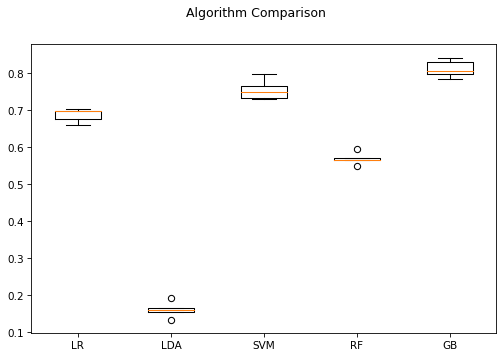

In [40]:
# Plot the results of each model's recall
fig = plt.figure(figsize=(8, 5))

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(results)
ax.set_xticklabels(names)

plt.show()

## Hyperparameter Tuning

In [41]:
# Gradient Boosting using randomized search
param_grid_gb = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.1, 0.2]
}

# SVM Pipeline setup
gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# Setup RandomizedSearchCV with fewer iterations and a limited parameter grid
random_search_gb = RandomizedSearchCV(
    gb_pipeline,
    param_distributions=param_grid_gb,
    n_iter=4, 
    scoring=scorer,
    cv=5,
    random_state=42,
    n_jobs=-1
)
random_search_gb.fit(X_train, y_train)

print('Best parameters are {} with CV score={}:' 
      .format(random_search_gb.best_params_, random_search_gb.best_score_)
)

Best parameters are {'classifier__n_estimators': 200, 'classifier__learning_rate': 0.2} with CV score=0.9558912386706948:


In [42]:
# Tune GB model
gb_tuned = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(n_estimators=200, learning_rate=0.2, random_state=42))
])

gb_tuned.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['tenure', 'avg_price',
                                                   'age_group']),
                                                 ('cat', OneHotEncoder(),
                                                  ['customer_gender',
                                                   'customer_country',
                                                   'referral_type'])])),
                ('classifier',
                 GradientBoostingClassifier(learning_rate=0.2, n_estimators=200,
                                            random_state=42))])

In [43]:
# Calculate accuracy, recall, precision, and F1-score on the train set
gb_random_train = model_performance_classification_sklearn(
    gb_tuned, X_train, y_train
)
print('Training performance:')
gb_random_train

Training performance:


,Accuracy,Recall,Precision,F1
0,0.99,0.97,1.00,0.98


* Recall increased to 97% from 81%.
* Accuracy, precision, and F1-score are also very high.

In [44]:
# Gradient Boosting pipeline configured with the best parameters
final_gb_model = Pipeline([
    ('preprocessor', preprocessor), 
    ('classifier', GradientBoostingClassifier(n_estimators=200, learning_rate=0.2, random_state=42))
])

# Using StratifiedKFold for cross-validation to handle class imbalance
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Conduct cross-validation
cv_scores = cross_val_score(final_gb_model, X_train, y_train, cv=kfold, scoring=scorer)

# Output the results
print('Recall Scores per Fold: ', cv_scores)
print('Average Recall: {:.2f}'.format(cv_scores.mean()))
print('Recall Standard Deviation: {:.2f}'.format(cv_scores.std()))

Recall Scores per Fold:  [0.97885196 0.92145015 0.93957704 0.96072508 0.95770393]
Average Recall: 0.95
Recall Standard Deviation: 0.02


* The average recall of 0.95 and standard deviation of 0.02 across five folds suggests that the model is generalizing well. 

In [45]:
# Calculate accuracy, recall, precision, and F1-score on the test set
gb_random_test = model_performance_classification_sklearn(gb_tuned, X_test, y_test)
print('Test performance:')
gb_random_test

Test performance:


,Accuracy,Recall,Precision,F1
0,0.99,0.96,1.00,0.98


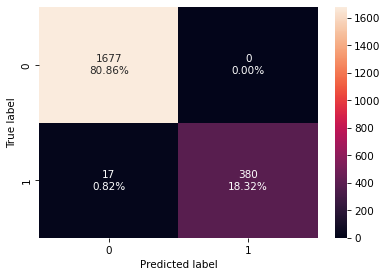

In [46]:
confusion_matrix_sklearn(gb_tuned, X_test, y_test)

* Gradient Boosting is performing well in all metrics on training and test sets. It is generalizing well, as the tuned model on testing data is only 1% lower in recall compared to the tuned model on training data.

In [47]:
# SVM using randomized search
param_grid_svm = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf']
}

svm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(random_state=42, class_weight='balanced'))
])

random_search_svm = RandomizedSearchCV(
    svm_pipeline,
    param_distributions=param_grid_svm,
    n_iter=6,  # Reduced number of iterations
    scoring=scorer,
    cv=5,
    random_state=42,
    n_jobs=-1
)

random_search_svm.fit(X_train, y_train)

print('Best parameters are {} with CV score={}:' 
      .format(random_search_svm.best_params_, random_search_svm.best_score_)
)

Best parameters are {'classifier__kernel': 'rbf', 'classifier__C': 1} with CV score=0.7601208459214501:


In [48]:
# Tune SVM model 
svm_tuned = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='rbf', C=1, class_weight='balanced', random_state=42))
])

svm_tuned.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['tenure', 'avg_price',
                                                   'age_group']),
                                                 ('cat', OneHotEncoder(),
                                                  ['customer_gender',
                                                   'customer_country',
                                                   'referral_type'])])),
                ('classifier',
                 SVC(C=1, class_weight='balanced', random_state=42))])

In [49]:
# Calculate accuracy, recall, precision, and F1-score on the train set
svm_random_train = model_performance_classification_sklearn(
    svm_tuned, X_train, y_train
)
print('Training performance:')
svm_random_train

Training performance:


,Accuracy,Recall,Precision,F1
0,0.75,0.82,0.43,0.56


In [50]:
# SVM pipeline configured with the best parameters
final_svm_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='rbf', C=1, class_weight='balanced', random_state=42))
])

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(final_svm_model, X_train, y_train, cv=kfold, scoring=scorer)

print('Recall Scores per Fold: ', cv_scores)
print('Average Recall: {:.2f}'.format(cv_scores.mean()))
print('Recall Standard Deviation: {:.2f}'.format(cv_scores.std()))

Recall Scores per Fold:  [0.74924471 0.79758308 0.7673716  0.73413897 0.73111782]
Average Recall: 0.76
Recall Standard Deviation: 0.02


In [51]:
# Calculate accuracy, recall, precision, and F1-score on the test set
svm_random_test = model_performance_classification_sklearn(svm_tuned, X_test, y_test)
print('Test performance:')
svm_random_test

Test performance:


,Accuracy,Recall,Precision,F1
0,0.72,0.73,0.38,0.50


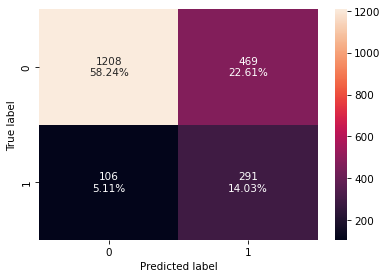

In [52]:
confusion_matrix_sklearn(svm_tuned, X_test, y_test)

* SVM is overfitting on training data, although not by a huge margin, with recall 0.82 vs testing data 0.73. Performance across all metrics is lower than Gradient Boosting.

## Model Performance Comparison and Final Model Selection

In [53]:
# Training performance comparison
models_train_comp_df = pd.concat(
    [
        gb_random_train.T,
        svm_random_train.T
    ],
    axis=1,
)
models_train_comp_df.columns = [
    'Gradient Boosting tuned with random search',
    'SVM tuned with random search',
]
print('Training performance comparison:')
models_train_comp_df

Training performance comparison:


,Gradient Boosting tuned with random search,SVM tuned with random search
Accuracy,0.99,0.75
Recall,0.97,0.82
Precision,1.00,0.43
F1,0.98,0.56


In [54]:
# Test performance comparison
models_test_comp_df = pd.concat(
    [
        gb_random_test.T,
        svm_random_test.T
    ],
    axis=1,
)
models_test_comp_df.columns = [
    'Gradient Boosting tuned with random search',
    'SVM tuned with random search',
]
print('Test performance comparison:')
models_test_comp_df

Test performance comparison:


,Gradient Boosting tuned with random search,SVM tuned with random search
Accuracy,0.99,0.72
Recall,0.96,0.73
Precision,1.00,0.38
F1,0.98,0.50


* The Gradient Boosting model tuned using randomized search is giving the best test recall of 0.96 and is generalizing well.

### Feature Importances

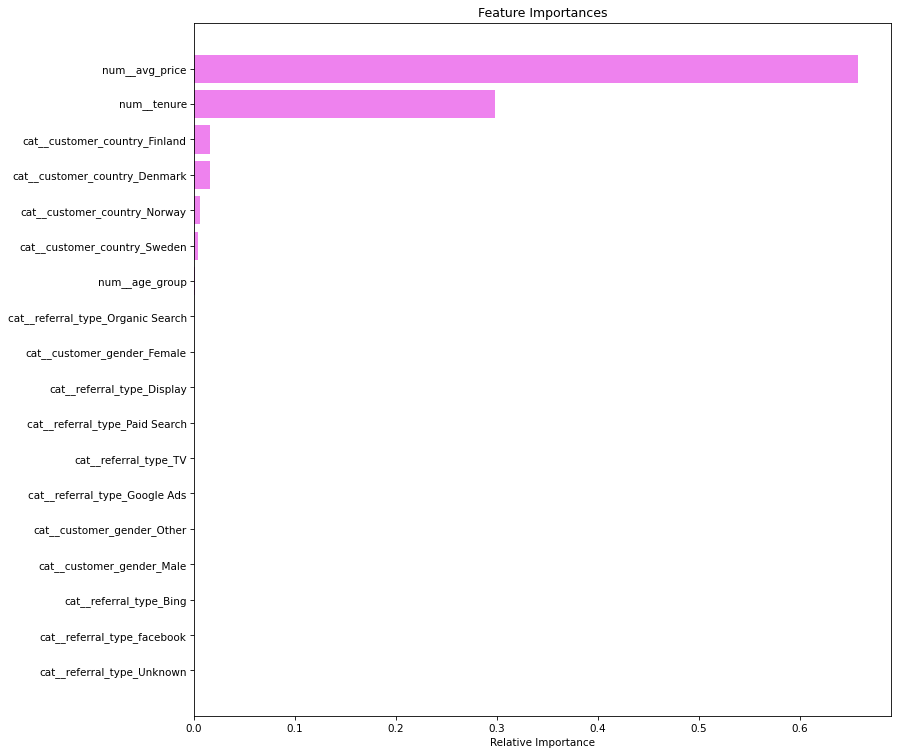

In [55]:
feature_names = X.columns
feature_importances = gb_tuned.named_steps['classifier'].feature_importances_
feature_names = gb_tuned.named_steps['preprocessor'].get_feature_names_out()
indices = np.argsort(feature_importances)

# Sort features by importance
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

plt.figure(figsize=(12, 12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

* `avg_price` is the most important feature, followed by `tenure` and `customer_country_Finland`.

## Business Insights and Recommendations

* `churn` and `avg_price` have increased steadily over the three years, which indicates that the company lacks effective marketing strategies.
    * The company should identify customers in the 'BASIC' plans or customers that have had a 'REDUCTION' in `subscription_type` and implement marketing strategies to retain these customers by offering incentives to upgrade.
    * The most frequent (mode) `avg_price` is \\$53, which aligns with the 'BASIC' plan, so the company should take a close look at this opportunity to target those customers and retain them with offers for upgraded plans.
* As noted earlier, the company should dive deep into what's working well in Norway and Sweden, which have much higher retention rates (up to 5x that of Finland), and test out those marketing strategies for customers in Finland.

[Back to TOC](#Table-of-Contents)